# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchsummary import summary
from sklearn.manifold import TSNE
from datetime import datetime

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# cifar10_dataset.data.mean(axis=(0, 1, 2))/255, cifar10_dataset.data.std(axis=(0, 1, 2))/255
cifar10_mean = np.array([0.49421428, 0.48513139, 0.45040909])
cifar10_std = np.array([0.24665252, 0.24289226, 0.26159238])

transform_train = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(cifar10_mean, cifar10_std),
])

unnormalize_transform = transforms.Normalize(-cifar10_mean/cifar10_std, 1/cifar10_std)

In [ ]:
cifar10_dataset = datasets.CIFAR10(root='dataset', train=True, download=True, transform=transform_train)
train_dataset, val_dataset = random_split(cifar10_dataset, [45000, 5000])
test_dataset = datasets.CIFAR10(root='dataset', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

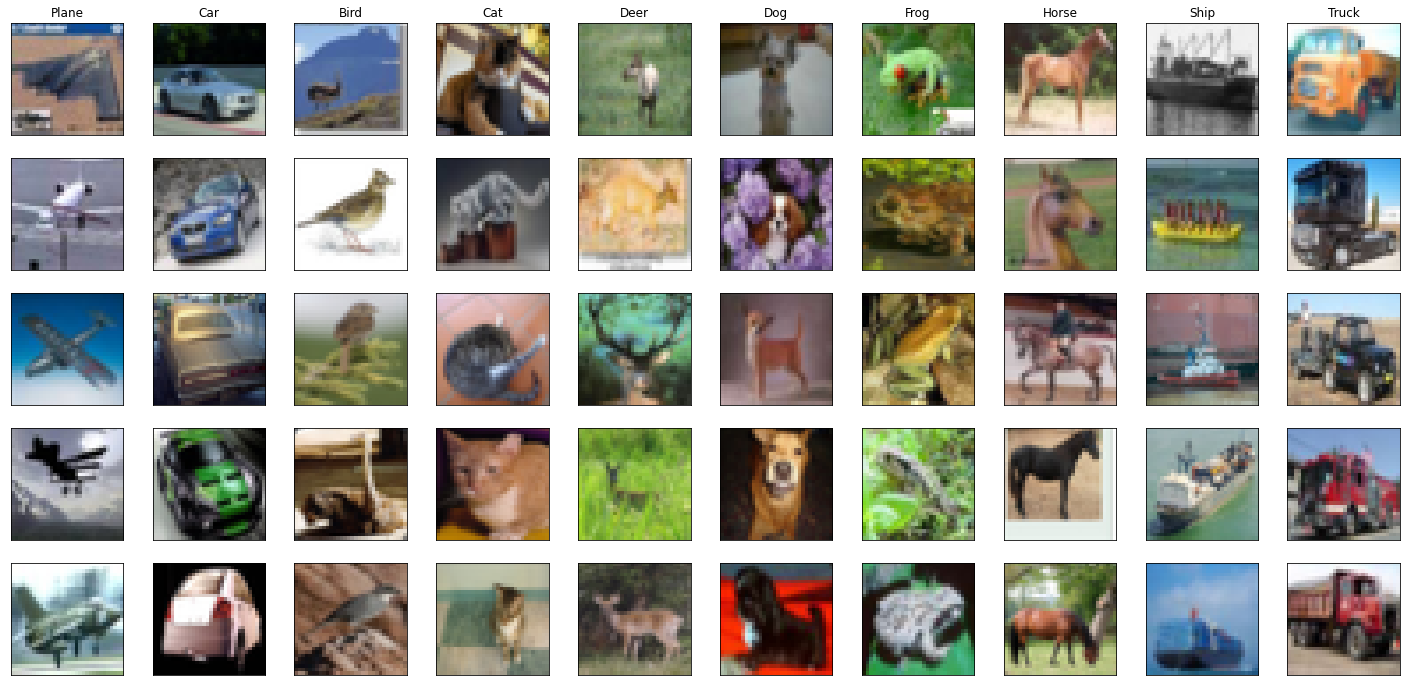

In [ ]:
num_images_to_display = 5
fig, axs = plt.subplots(num_images_to_display, len(classes), figsize=(25, 12))

for class_idx in range(len(classes)):
  axs[0][class_idx].set_title(classes[class_idx].capitalize())

for class_idx, class_name in enumerate(classes):
  class_random_images = cifar10_dataset.data[np.random.choice(np.where(np.array(cifar10_dataset.targets) == class_idx)[0], num_images_to_display)]
  for i, img in enumerate(class_random_images):
    axs[i][class_idx].imshow(img)
    axs[i][class_idx].set_yticks([])
    axs[i][class_idx].set_xticks([])

## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model)

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:
# Sample network (with this model you'll get test accuracy above 85% but not 90%)
class SampleNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_space = nn.Sequential( # Input: (B, 3, 32, 32)
      nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3), # (B, 6, 30, 30)
      nn.BatchNorm2d(8),
      nn.ReLU(),
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=1), # (B, 12, 28, 28)
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2), # (B, 12, 14, 14)
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7, padding=1), # (B, 20, 10, 10)
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=9, padding=1), # (B, 64, 4, 4)
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Flatten(), # (B, 1024)
      nn.Dropout(p=0.5),
      nn.Linear(1024, 256), # (B, 256)
      nn.BatchNorm1d(256), 
      nn.ReLU(),
    )
    self.dropout = nn.Dropout(p=0.5)
    self.classifier = nn.Linear(256, 10)

  def forward(self, x):
    return self.classifier(self.dropout(self.feature_space(x)))

In [ ]:
# ResNet18 implementation

class ResNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    assert stride == 1 or stride == 2

    super(ResNetBlock, self).__init__()

    self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
    )

    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels)
      )
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    return F.relu(self.shortcut(x) + self.block(x))


class ResNet18(nn.Module):
  def __init__(self, img_channels=3, num_classes=10):
    super(ResNet18, self).__init__()

    self.feature_space = nn.Sequential( # Input: (B, 3, 32, 32)
        nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1), # (B, 64, 32, 32)
        nn.BatchNorm2d(64),
        nn.ReLU(),

        ResNetBlock(64, 256, stride=1), # (B, 256, 32, 32)
        ResNetBlock(256, 256, stride=1), # (B, 256, 32, 32)

        ResNetBlock(256, 512, stride=2), # (B, 512, 16, 16)
        ResNetBlock(512, 512, stride=1), # (B, 512, 16, 16)

        ResNetBlock(512, 1024, stride=2), # (B, 1024, 8, 8)
        ResNetBlock(1024, 1024, stride=1), # (B, 1024, 8, 8)

        ResNetBlock(1024, 2048, stride=2), # (B, 2048, 4, 4)
        ResNetBlock(2048, 2048, stride=1), # (B, 2048, 4, 4)

        nn.AvgPool2d(4), # (B, 2048, 1, 1)
        nn.Flatten(), # (B, 2048)
    )

    self.classifier = nn.Linear(2048, num_classes)
  
  def forward(self, x):
    return self.classifier(self.feature_space(x))

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
model = ResNet18().to(device)
summary(model, (3, 32, 32), 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           1,792
       BatchNorm2d-2           [64, 64, 32, 32]             128
              ReLU-3           [64, 64, 32, 32]               0
            Conv2d-4          [64, 256, 32, 32]          16,640
       BatchNorm2d-5          [64, 256, 32, 32]             512
            Conv2d-6          [64, 256, 32, 32]         147,456
       BatchNorm2d-7          [64, 256, 32, 32]             512
              ReLU-8          [64, 256, 32, 32]               0
            Conv2d-9          [64, 256, 32, 32]         589,824
      BatchNorm2d-10          [64, 256, 32, 32]             512
      ResNetBlock-11          [64, 256, 32, 32]               0
         Identity-12          [64, 256, 32, 32]               0
           Conv2d-13          [64, 256, 32, 32]         589,824
      BatchNorm2d-14          [64, 256,

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
num_epochs=35

train_loss_arr, val_loss_arr = [], []
train_acc_arr, val_acc_arr = [], []
for epoch in range(num_epochs):
  train_loss, val_loss = .0, .0
  train_acc, val_acc = .0, .0

  model.train()
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    train_loss += loss.item() * images.size(0)
    train_acc += torch.sum(torch.max(outputs, axis=1)[1] == labels).cpu().item()
    loss.backward()
    optimizer.step()
  scheduler.step()

  model.eval()
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    val_loss += loss.item() * images.size(0)
    val_acc += torch.sum(torch.max(outputs, axis=1)[1] == labels).cpu().item()

  train_loss /= len(train_loader.dataset)
  val_loss /= len(val_loader.dataset)
  train_acc /= len(train_loader.dataset)
  val_acc /= len(val_loader.dataset)

  train_loss_arr.append(train_loss)
  val_loss_arr.append(val_loss)
  train_acc_arr.append(train_acc)
  val_acc_arr.append(val_acc)

  print(f"[Epoch {epoch}]\t"
        f"[{datetime.now().strftime('%H:%M:%S')}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Train Accuracy: {train_acc:.2f}\t"
        f"Validation Loss: {val_loss:.4f}\t\t"
        f"Validation Accuracy: {val_acc:.2f}")

[Epoch 0]	[18:28:13]	Train Loss: 1.6003	Train Accuracy: 0.43	Validation Loss: 1.2983		Validation Accuracy: 0.53
[Epoch 1]	[18:32:45]	Train Loss: 1.0466	Train Accuracy: 0.63	Validation Loss: 1.4428		Validation Accuracy: 0.55
[Epoch 2]	[18:37:17]	Train Loss: 0.8723	Train Accuracy: 0.70	Validation Loss: 0.8079		Validation Accuracy: 0.72
[Epoch 3]	[18:41:47]	Train Loss: 0.6823	Train Accuracy: 0.77	Validation Loss: 0.6540		Validation Accuracy: 0.78
[Epoch 4]	[18:46:18]	Train Loss: 0.5842	Train Accuracy: 0.80	Validation Loss: 0.6186		Validation Accuracy: 0.79
[Epoch 5]	[18:50:49]	Train Loss: 0.5155	Train Accuracy: 0.82	Validation Loss: 0.5647		Validation Accuracy: 0.81
[Epoch 6]	[18:55:21]	Train Loss: 0.4588	Train Accuracy: 0.84	Validation Loss: 0.5397		Validation Accuracy: 0.82
[Epoch 7]	[18:59:53]	Train Loss: 0.4197	Train Accuracy: 0.86	Validation Loss: 0.5129		Validation Accuracy: 0.82
[Epoch 8]	[19:04:25]	Train Loss: 0.3852	Train Accuracy: 0.87	Validation Loss: 0.5822		Validation Accurac

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

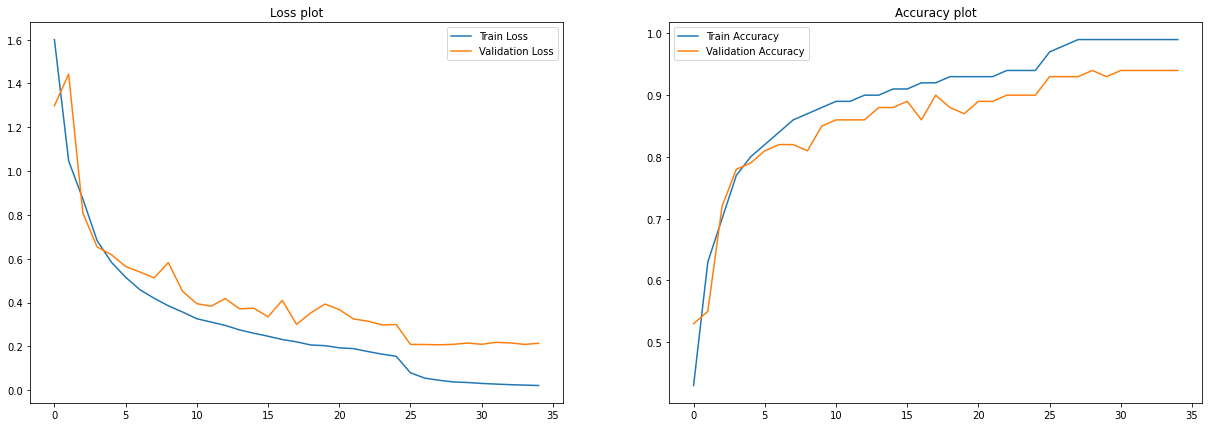

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(21, 7))

axs[0].set_title("Loss plot")
axs[0].plot(train_loss_arr)
axs[0].plot(val_loss_arr)
axs[0].legend(["Train Loss", "Validation Loss"]);

axs[1].set_title("Accuracy plot")
axs[1].plot(train_acc_arr)
axs[1].plot(val_acc_arr)
axs[1].legend(["Train Accuracy", "Validation Accuracy"]);

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
test_acc = .0

model.eval()
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  test_acc += (outputs.max(axis=1)[1] == labels).sum().item()

test_acc /= len(test_loader.dataset)

test_acc

0.9365


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

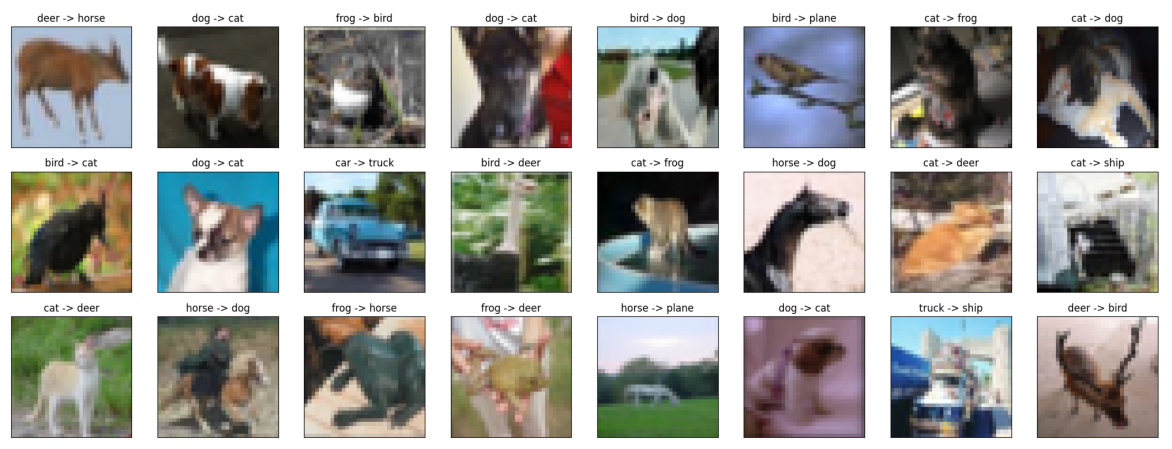

In [ ]:
num_rows, num_cols = 3, 8
num_wrong_pred_to_show = num_rows * num_cols

wrong_labeled_imgs = []
model.eval()
for images, labels in DataLoader(dataset=test_dataset, batch_size=32, shuffle=True):
  if len(wrong_labeled_imgs) >= num_wrong_pred_to_show:
    break
  images, labels = images.to(device), labels.to(device)
  outputs = model(images).max(axis=1)[1]
  wrong_label_mask = (outputs != labels)
  for idx in torch.where(wrong_label_mask)[0]:
    wrong_labeled_imgs.append([
        unnormalize_transform(images[idx]).transpose(0, 1).transpose(1, 2).cpu(),
        classes[labels[idx]],
        classes[outputs[idx]],
    ])
  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 9))
for i in range(num_wrong_pred_to_show):
  img, label, pred = wrong_labeled_imgs[i]
  axs[i//num_cols][i%num_cols].imshow(img)
  axs[i//num_cols][i%num_cols].set_title(f"{label} -> {pred}")
  axs[i//num_cols][i%num_cols].set_yticks([])
  axs[i//num_cols][i%num_cols].set_xticks([])

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
train_samples_feature_space = torch.zeros(50000, 2048)

train_dataset_with_test_transform = datasets.CIFAR10(root='dataset', train=True, transform=transform_test)

model.eval()
for idx, (images, labels) in enumerate(DataLoader(dataset=train_dataset_with_test_transform, batch_size=64, shuffle=False)):
  train_samples_feature_space[idx*64:idx*64+labels.size(0)] = model.feature_space(images.to(device)).detach().cpu()

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

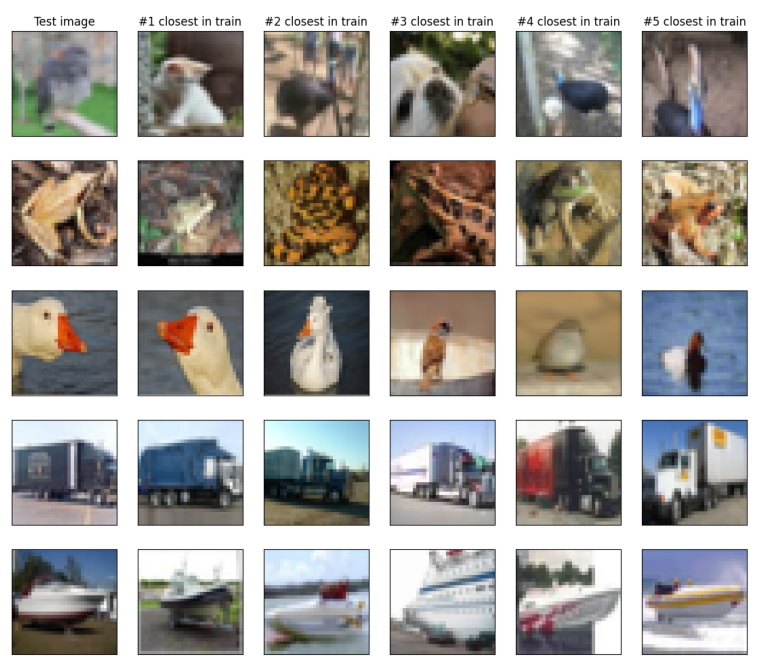

In [ ]:
num_rows, num_cols = 5, 6
fig, axs = plt.subplots(num_rows, num_cols, figsize=(14, 16))
for i in range(num_rows):
  for j in range(num_cols):
    axs[i][j].set_yticks([])
    axs[i][j].set_xticks([])
axs[0][0].set_title("Test image")
for i in range(1, num_cols):
  axs[0][i].set_title(f"#{i} closest in train")


cnt = 0
while cnt < num_rows:
  img, label = test_dataset[np.random.choice(len(test_dataset))]

  test_sample_feature_space = model.feature_space(img.to(device).unsqueeze(0))
  
  if model.classifier(test_sample_feature_space).max(axis=1)[1] != label:
    continue
  
  dist = torch.linalg.norm(train_samples_feature_space - test_sample_feature_space.squeeze().detach().cpu(), dim=1)
  knn = dist.topk(num_cols-1, largest=False)

  axs[cnt][0].imshow(unnormalize_transform(img).permute(1, 2, 0))
  for i, train_idx in enumerate(knn[1]):
    axs[cnt][i+1].imshow(unnormalize_transform(train_dataset_with_test_transform[train_idx][0]).permute(1, 2, 0))

  cnt += 1

### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
tsne = TSNE(2)
random_indices = np.random.choice(train_samples_feature_space.shape[0], 2000, replace=False)
labels = np.array(train_dataset_with_test_transform.targets)[random_indices]
tsne_result = tsne.fit_transform(train_samples_feature_space[random_indices])
tsne_result.shape

(2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

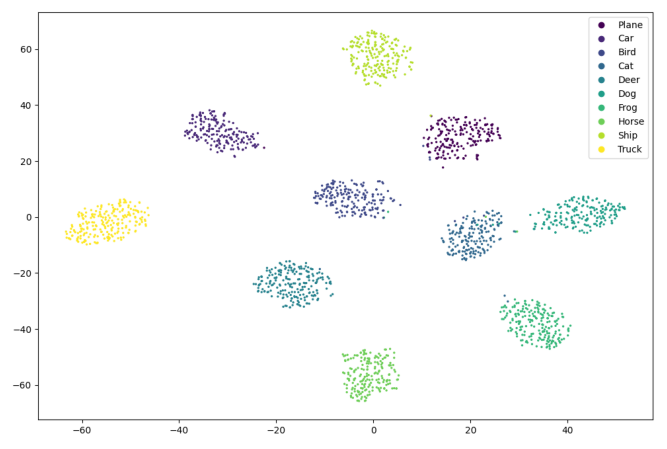

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=2, c=labels)

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import numpy as np
import torchvision.transforms.functional as TF

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class ColorizationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform
    self.to_black_and_white_transform = transforms.Grayscale()
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    img = self.dataset.data[idx]

    if self.transform is not None:
      img = self.transform(img)

    gray_img = self.to_black_and_white_transform(img)

    return gray_img, img

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
transform_dataset = transforms.Compose([
  transforms.ToTensor(),
])

cifar10_train_dataset = datasets.CIFAR10(root='dataset', train=True, download=True)
cifar10_test_dataset = datasets.CIFAR10(root='dataset', train=False, download=True)

train_dataset, val_dataset = random_split(ColorizationDataset(cifar10_train_dataset, transform_dataset), [45000, 5000])
test_dataset = ColorizationDataset(cifar10_test_dataset, transform_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

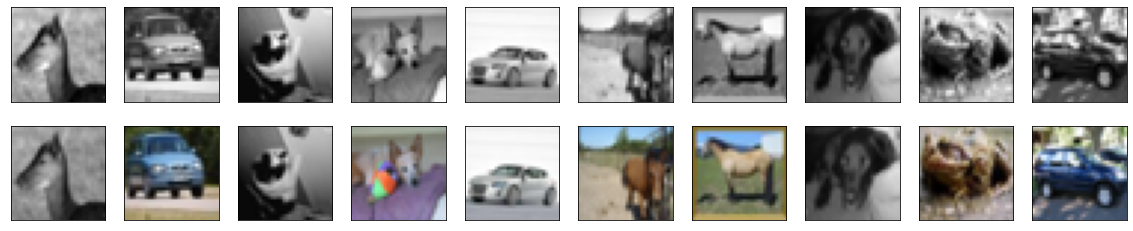

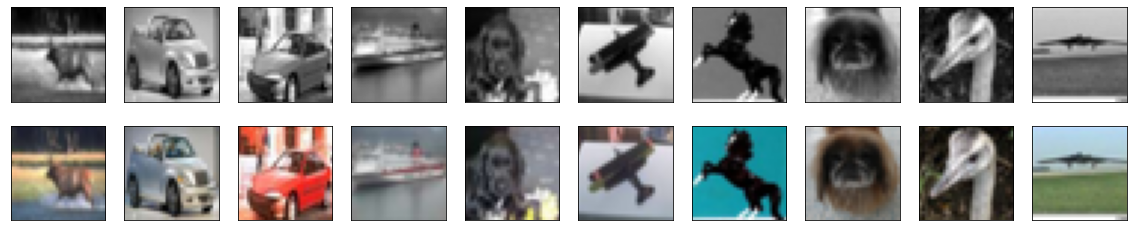

In [ ]:
num_images_to_display = 10

for i in range(2):
  fig, axs = plt.subplots(2, num_images_to_display, figsize=(20, 4))

  for i in range(num_images_to_display):
    gray_img, img = train_dataset[np.random.choice(len(train_dataset))]
    axs[0][i].imshow(gray_img.permute(1, 2, 0).squeeze(), cmap='gray')
    axs[1][i].imshow(img.permute(1, 2, 0))
    for j in range(2):
      axs[j][i].set_yticks([])
      axs[j][i].set_xticks([])
  
  plt.plot()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
# Code from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/image_segmentation/semantic_segmentation_unet/model.py

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
        nn.ConvTranspose2d(
          feature*2, feature, kernel_size=2, stride=2,
        )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
model = UNET(in_channels=1, out_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 120, 200], gamma=0.1)

In [ ]:
num_epochs=300

train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
  train_loss, val_loss = .0, .0

  model.train()
  for gray_images, images in train_loader:
    gray_images, images = gray_images.to(device), images.to(device)
    optimizer.zero_grad()
    outputs = model(gray_images)
    loss = criterion(outputs, images)
    train_loss += loss.item() * images.size(0)
    loss.backward()
    optimizer.step()
  scheduler.step()

  model.eval()
  for gray_images, images in val_loader:
    gray_images, images = gray_images.to(device), images.to(device)
    outputs = model(gray_images)
    loss = criterion(outputs, images)
    val_loss += loss.item() * images.size(0)

  train_loss /= len(train_loader.dataset)
  val_loss /= len(val_loader.dataset)

  train_loss_arr.append(train_loss)
  val_loss_arr.append(val_loss)

  print(f"[Epoch {epoch}]\t"
        f"[{datetime.now().strftime('%H:%M:%S')}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

[Epoch 0]	[00:51:54]	Train Loss: 0.0112	Validation Loss: 0.0063
[Epoch 1]	[00:52:50]	Train Loss: 0.0063	Validation Loss: 0.0062
[Epoch 2]	[00:53:46]	Train Loss: 0.0060	Validation Loss: 0.0056
[Epoch 3]	[00:54:42]	Train Loss: 0.0058	Validation Loss: 0.0085
[Epoch 4]	[00:55:39]	Train Loss: 0.0057	Validation Loss: 0.0054
[Epoch 5]	[00:56:35]	Train Loss: 0.0057	Validation Loss: 0.0066
[Epoch 6]	[00:57:31]	Train Loss: 0.0056	Validation Loss: 0.0055
[Epoch 7]	[00:58:26]	Train Loss: 0.0055	Validation Loss: 0.0053
[Epoch 8]	[00:59:22]	Train Loss: 0.0055	Validation Loss: 0.0062
[Epoch 9]	[01:00:18]	Train Loss: 0.0055	Validation Loss: 0.0055
[Epoch 10]	[01:01:14]	Train Loss: 0.0053	Validation Loss: 0.0056
[Epoch 11]	[01:02:10]	Train Loss: 0.0053	Validation Loss: 0.0053
[Epoch 12]	[01:03:04]	Train Loss: 0.0053	Validation Loss: 0.0056
[Epoch 13]	[01:03:57]	Train Loss: 0.0051	Validation Loss: 0.0069
[Epoch 14]	[01:04:51]	Train Loss: 0.0053	Validation Loss: 0.0057
[Epoch 15]	[01:05:45]	Train Loss: 0

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

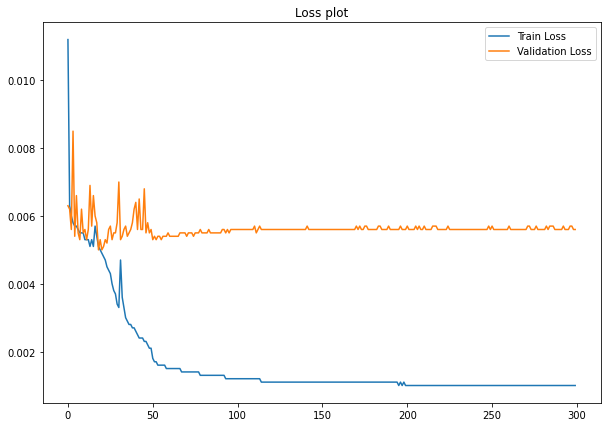

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Loss plot")
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.legend(["Train Loss", "Validation Loss"]);

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



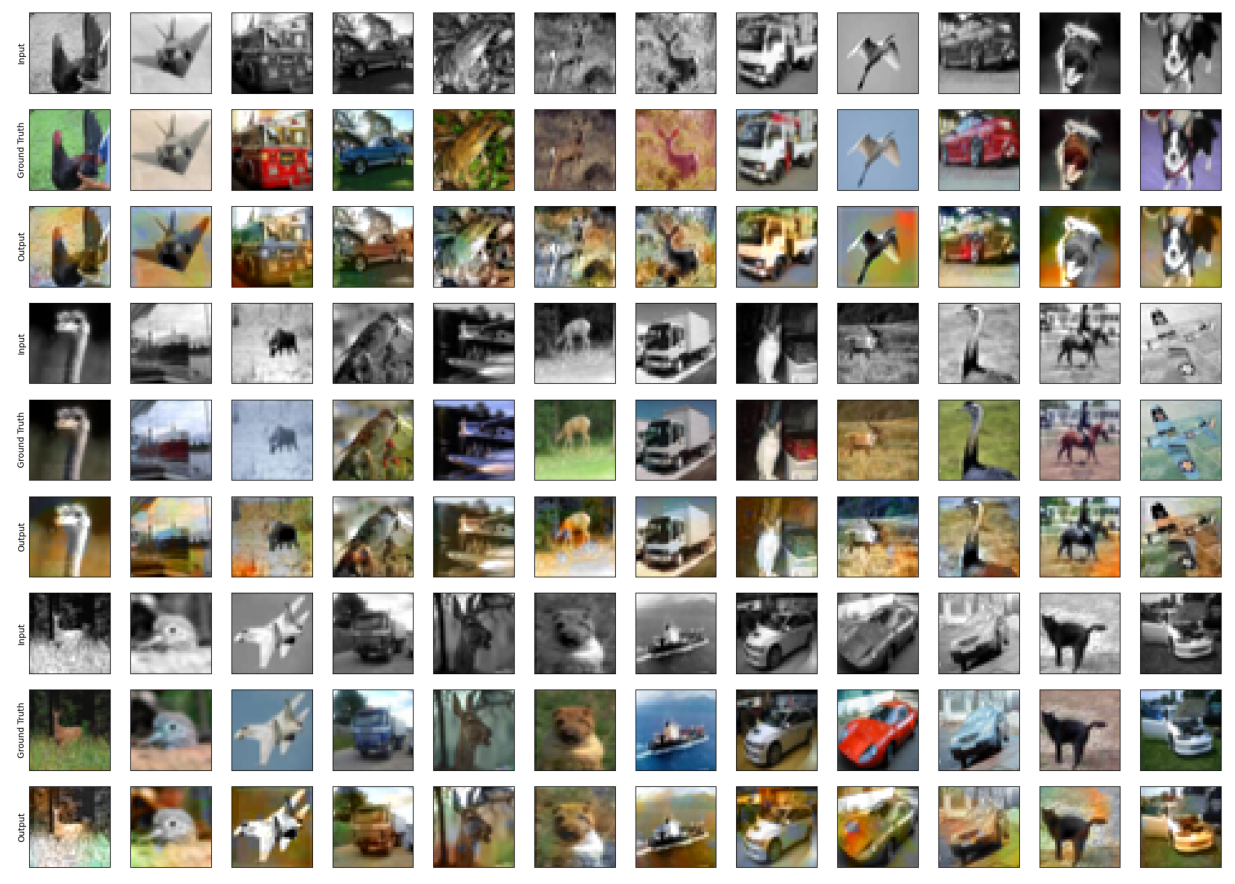

In [ ]:
num_images_to_display = 12
num_rows, num_cols = 3, 12
fig, axs = plt.subplots(num_rows*3, num_cols, figsize=(25, num_rows*6))

for i, title in enumerate(["Input", "Ground Truth", "Output"]):
  for offset in [0, 3, 6]:
    axs[offset+i][0].set_ylabel(title)

for i in range(num_rows*num_cols):
  row_offset = (i//num_cols)*3
  gray_img, img = test_dataset[np.random.choice(len(test_dataset))]
  output = model(gray_img.to(device).unsqueeze(0)).squeeze().detach().cpu()
  axs[0+row_offset][i%num_cols].imshow(gray_img.permute(1, 2, 0).squeeze(), cmap='gray')
  axs[1+row_offset][i%num_cols].imshow(img.permute(1, 2, 0))
  axs[2+row_offset][i%num_cols].imshow(output.permute(1, 2, 0))
  for j in range(3):
    axs[j+row_offset][i%num_cols].set_yticks([])
    axs[j+row_offset][i%num_cols].set_xticks([])